# Amazon Product Reviews Classification

## Load Libraries & Data

In [1]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, RegexpTokenizer
from textblob import TextBlob 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import Perceptron
from sklearn.feature_extraction.text import TfidfVectorizer

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
seed = 125
data = pd.read_csv('~/data/reviews_training.csv', index_col=0)

In [3]:
data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Label
33456,B00689J5PI,"[0, 1]",4.0,I saw Rihanna perform this on American Idol an...,"02 12, 2013",A1PQ1PESSO8CMO,Ginger Christmas,Good song,1360627200,4
51604,B000KIPT30,"[0, 0]",3.0,My title says it all. I didn't like the AC ad...,"03 16, 2014",A18LZ6VHS4DK69,Wesley Newell,"It worked, but should be usb powered",1394928000,5
20590,B001CH2X5K,"[3, 3]",4.0,We have had this slide chair for 2+ months now...,"05 14, 2010",A14QSFDZJXEXMI,H. Flowers,"Excellent for an active baby, but be careful o...",1273795200,3
57999,B002Z9JWZ8,"[1, 1]",5.0,"I don't own the SRH840s, but rather the SRH440...","07 3, 2013",A3K6M4WXNTYQEM,Keane O'Kelley,Great upgrade for SRH440!,1372809600,5
7653,B0009H51MG,"[0, 0]",5.0,I like Fram Air Filters (not oil ones) and thi...,"02 11, 2010",A1U8MWMH8RNYUV,"C. Snead ""STi Mtn Man""",Excellent OEM Replacement,1265846400,2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45500 entries, 33456 to 13229
Data columns (total 10 columns):
asin              45500 non-null object
helpful           45500 non-null object
overall           45500 non-null float64
reviewText        45486 non-null object
reviewTime        45500 non-null object
reviewerID        45500 non-null object
reviewerName      45312 non-null object
summary           45500 non-null object
unixReviewTime    45500 non-null int64
Label             45500 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 3.8+ MB


Missing data in the reviewText and reviewerName columns

In [5]:
data.overall.describe()

count    45500.000000
mean         4.317868
std          1.040274
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

## Feature Exploration

### Individual

#### Label

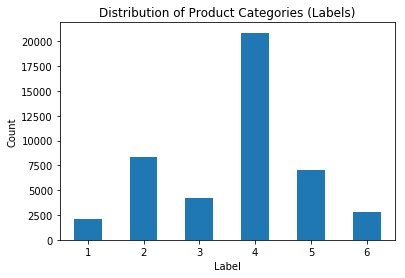

In [6]:
df = data.Label.value_counts().reset_index()
df.columns = ['Label', 'Count']
df.sort_values('Label', inplace=True)
df.set_index('Label', inplace=True)
df.plot(kind='bar')
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.ylabel('Count')
plt.title('Distribution of Product Categories (Labels)')
plt.show()

There is class imbalance. A large proportion of the labels are 4. We will need to downsample or upsample the data before modeling.

#### Product Ratings

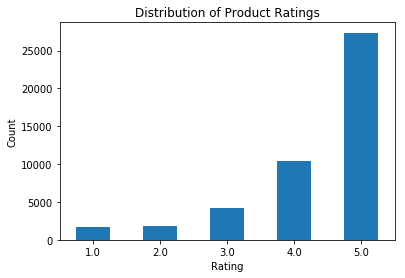

In [7]:
df = data.overall.value_counts().reset_index()
df.columns = ['Rating', 'Count']
df.sort_values('Rating', inplace=True)
df.set_index('Rating', inplace=True)
df.plot(kind='bar')
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.ylabel('Count')
plt.title('Distribution of Product Ratings')
plt.show()

#### Product IDs

In [8]:
num_prods = len(data.asin)
num_prods_unique = len(data.asin.unique())

print('There are {} total products and {} unique products.'.format(num_prods, num_prods_unique))

There are 45500 total products and 11699 unique products.


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


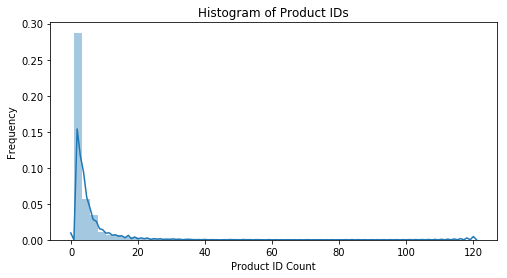

In [9]:
plt.figure(figsize=(8,4))
sns.distplot(data.asin.value_counts())
plt.title('Histogram of Product IDs')
plt.xlabel('Product ID Count')
plt.ylabel('Frequency')
plt.show()

In [10]:
data.asin.value_counts().head(10)

B003VWJ2K8    120
B0002E1G5C    104
B0007NFL18     86
B000084T18     84
B0002F7K7Y     82
B003VWKPHC     77
B00005YW4H     71
B000CITK8S     71
B00004T9UF     59
B0006ZQ9BS     59
Name: asin, dtype: int64

In [11]:
data.asin.value_counts().tail(10)

B005PK4ZHY    1
B000002MBG    1
B0032FOOQQ    1
B000G2HSMA    1
B002XLK22A    1
B000002UFV    1
B00008X35U    1
B007BH1V1W    1
B003EKAO1S    1
B00439HF2A    1
Name: asin, dtype: int64

In [12]:
data.asin.value_counts().describe()

count    11699.000000
mean         3.889221
std          5.694256
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        120.000000
Name: asin, dtype: float64

#### Reviewer IDs

In [13]:
num_rev = len(data.reviewerID)
num_rev_unique = len(data.reviewerID.unique())

print('There are {} total reviewer IDs and {} unique reviewer IDs.'.format(num_rev, num_rev_unique))

There are 45500 total reviewer IDs and 7194 unique reviewer IDs.


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


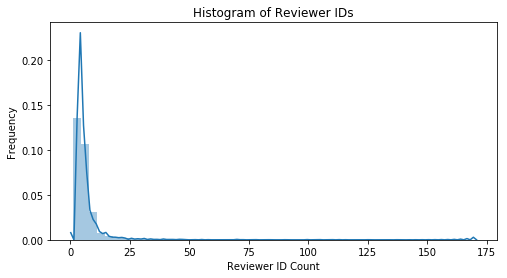

In [14]:
plt.figure(figsize=(8,4))
sns.distplot(data.reviewerID.value_counts())
plt.title('Histogram of Reviewer IDs')
plt.xlabel('Reviewer ID Count')
plt.ylabel('Frequency')
plt.show()

In [15]:
data.reviewerID.value_counts().head(10)

A1GN8UJIZLCA59    170
A14GK0E64J0WAS    157
A200C7YQJ45LRR    138
A1J5KCZC8CMW9I    125
A26NLSTT75FMJM    115
A2582KMXLK2P06    113
A1QEWOSV05RYEO    110
A24N1BAS3CU27H    105
A1IKOYZVFHO1XP    100
A2ETZ7GF5B1712    100
Name: reviewerID, dtype: int64

In [16]:
data.reviewerID.value_counts().tail(10)

A33CYHP1759V4W    1
A2HVJSTFR0M8GL    1
A2M56XGFARVRDJ    1
A24FCRSK4MJWZ9    1
A1J9RW7V666J3U    1
A1W8LGW2E1BVIS    1
A1HKBVOZ6VS1AN    1
A23LCEFE2BWE5F    1
A2UV3UX5OEDUXB    1
A22VYOT4RQ092Z    1
Name: reviewerID, dtype: int64

In [17]:
data.reviewerID.value_counts().describe()

count    7194.000000
mean        6.324715
std         7.473922
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max       170.000000
Name: reviewerID, dtype: float64

#### Reviewer Names

In [18]:
num_name = len(data.reviewerName)
num_name_unique = len(data.reviewerName.unique())

print('There are {} total reviewer names and {} unique reviewer names.'.format(num_name, num_name_unique))

There are 45500 total reviewer names and 6885 unique reviewer names.


There are more unique reviewer IDs than reviewer names (7194 vs 6885). But there is also missing data in the reviewerNames field.

In [19]:
num_name_miss = len(data.reviewerName) - len(data.reviewerName.dropna())
print('{} reviews are missing reviewer names.'.format(num_name_miss))

188 reviews are missing reviewer names.


In [20]:
data['reviewerName'] = data.reviewerName.fillna('Unknown')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


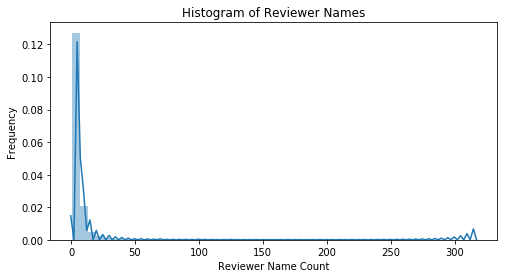

In [21]:
plt.figure(figsize=(8,4))
sns.distplot(data.reviewerName.value_counts())
plt.title('Histogram of Reviewer Names')
plt.xlabel('Reviewer Name Count')
plt.ylabel('Frequency')
plt.show()

In [22]:
data.reviewerName.value_counts().head(10)

Amazon Customer                                  316
Unknown                                          188
P Magnum                                         170
Paul Allaer                                      157
Anthony Rupert "shut up, Shut Up, SHUT UP!!!"    138
H3@+h "Over 1500 reviews!"                       125
B. E Jackson                                     113
finulanu "&#34;the mysterious&#34;"              112
Michael Brent Faulkner, Jr. "Brent Faulkner"     110
Nse Ette                                         105
Name: reviewerName, dtype: int64

In [23]:
data.reviewerName.value_counts().tail(10)

Hpsweet                             1
Jason W. Bellenger                  1
S. Duncan "Romantic Island Girl"    1
Tuco                                1
Mark D. Davis                       1
Goodrench                           1
Fawkestear                          1
Picky                               1
R. A. Macgregor "StreetRod"         1
Thomas Rogers                       1
Name: reviewerName, dtype: int64

In [24]:
data.reviewerName.value_counts().describe()

count    6885.000000
mean        6.608569
std         8.961131
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max       316.000000
Name: reviewerName, dtype: float64

#### Review Time (raw)

##### Year

In [25]:
data['reviewYear'] = data.reviewTime.apply(lambda x: int(x.split(' ')[-1]))

In [26]:
data.reviewYear.describe()

count    45500.000000
mean      2009.569297
std          4.430578
min       1998.000000
25%       2005.000000
50%       2012.000000
75%       2013.000000
max       2014.000000
Name: reviewYear, dtype: float64

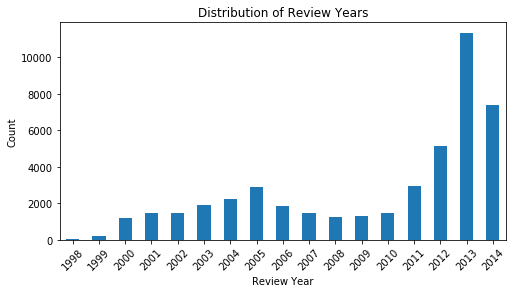

In [27]:
df = data.reviewYear.value_counts().reset_index()
df.columns = ['Review Year', 'Count']
df.sort_values('Review Year', inplace=True)
df.set_index('Review Year', inplace=True)
df.plot(kind='bar', figsize=(8,4))
plt.xticks(rotation=45)
plt.legend().set_visible(False)
plt.ylabel('Count')
plt.title('Distribution of Review Years')
plt.show()

##### Month

In [28]:
data['reviewMonth'] = data.reviewTime.apply(lambda x: x.split(' ')[0])

In [29]:
data.reviewMonth.describe()

count     45500
unique       12
top          01
freq       4443
Name: reviewMonth, dtype: object

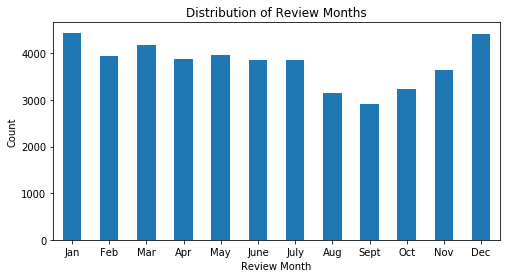

In [30]:
df = data.reviewMonth.value_counts().reset_index()
df.columns = ['Review Month', 'Count']
df.sort_values('Review Month', inplace=True)
df.set_index('Review Month', inplace=True)
df.plot(kind='bar', figsize=(8,4))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(range(0,12), months, rotation=0)
plt.legend().set_visible(False)
plt.ylabel('Count')
plt.title('Distribution of Review Months')
plt.show()

#### Review Time (Unix)

##### Day of Week

In [31]:
data['DayOfWeek'] = data.unixReviewTime.apply(lambda x: datetime.fromtimestamp(x/1000).strftime("%A"))

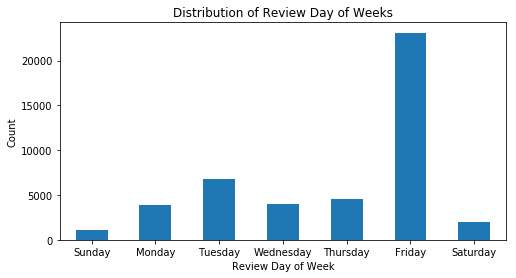

In [32]:
df = data.DayOfWeek.value_counts().reset_index()
df.columns = ['Review Day of Week', 'Count']
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df.set_index('Review Day of Week', inplace=True)
df = df.reindex(days)
df.plot(kind='bar', figsize=(8,4))
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.ylabel('Count')
plt.title('Distribution of Review Day of Weeks')
plt.show()

#### Helpful

In [33]:
data['helpful'] = data.helpful.apply(lambda x: x.lstrip('[').rstrip(']').split(','))

In [34]:
def helpful_divide(x):
    try:
        return float(int(x[0]))/int(x[1])
    except ZeroDivisionError:
        if int(x[0]) == int(x[1]) == 0:
            return 'N/A'
        else:
            return 0

In [35]:
data['helpfulPercentage'] = data.helpful.apply(lambda x: helpful_divide(x)) 

In [36]:
data.helpfulPercentage.describe()

count     45500
unique      610
top         N/A
freq      20900
Name: helpfulPercentage, dtype: object

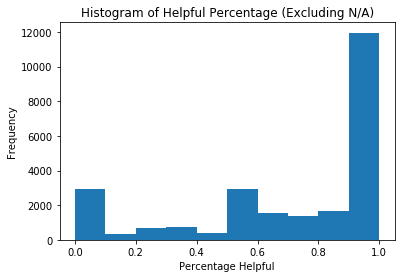

In [37]:
data[data.helpfulPercentage!='N/A']['helpfulPercentage'].plot(kind='hist')
plt.xlabel('Percentage Helpful')
plt.title('Histogram of Helpful Percentage (Excluding N/A)')
plt.show()

In [38]:
def helpful_ranking(num):
    if type(num) == str:
        return 'N/A'
    elif 0 <= num < 0.2:
        return 1
    elif 0.2 <= num < 0.4:
        return 2
    elif 0.4 <= num < 0.6:
        return 3
    elif 0.6 <= num < 0.8:
        return 4
    elif 0.8 <= num <= 1.0:
        return 5

In [39]:
data['helpfulRank'] = data.helpfulPercentage.apply(lambda x: helpful_ranking(x))

#### Review Text

In [40]:
data['reviewText'] = data.reviewText.str.lower()

In [41]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english')) 

In [42]:
data['reviewText'] = data.reviewText.astype(str)
data['reviewText'] = data.reviewText.apply(lambda x: word_tokenize(x))
data['reviewText'] = data.reviewText.apply(lambda x: [w for w in x if not w in stop_words])
data['reviewText'] = data.reviewText.apply(lambda x: [''.join(c for c in s if c not in string.punctuation) for s in x])
data['reviewText'] = data.reviewText.apply(lambda x: [s for s in x if s])

In [43]:
data['reviewLength'] = data.reviewText.apply(lambda x: len(x))

#### Summary

In [44]:
data['summary'] = data.summary.astype(str)
data['summary'] = data.summary.apply(lambda x: TextBlob(x))

In [45]:
def sentiment(blob):
    for sentence in blob.sentences:
        return sentence.sentiment.polarity

In [46]:
data['sentimentSummary'] = data.summary.apply(lambda x: sentiment(x))

In [47]:
data[['summary', 'sentimentSummary']].head(10)

,summary,sentimentSummary
33456,"(G, o, o, d, , s, o, n, g)",0.700000
51604,"(I, t, , w, o, r, k, e, d, ,, , b, u, t, , ...",0.000000
20590,"(E, x, c, e, l, l, e, n, t, , f, o, r, , a, ...",0.255556
57999,"(G, r, e, a, t, , u, p, g, r, a, d, e, , f, ...",1.000000
7653,"(E, x, c, e, l, l, e, n, t, , O, E, M, , R, ...",1.000000
922,"(S, e, a, s, o, n, , 5)",0.000000
40148,"(G, l, o, o, m, y, , a, n, d, , n, i, c, e, ...",0.600000
33179,"(T, h, i, s, , i, s, , t, h, e, , p, e, a, ...",0.000000
11269,"(C, o, b, r, a, , D, e, l, u, x, , J, r, , ...",0.000000
8413,"(T, h, e, , B, E, S, T)",1.000000


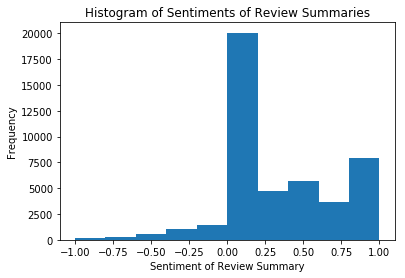

In [48]:
data.sentimentSummary.plot(kind='hist')
plt.xlabel('Sentiment of Review Summary')
plt.title('Histogram of Sentiments of Review Summaries')
plt.show()

### Multiple

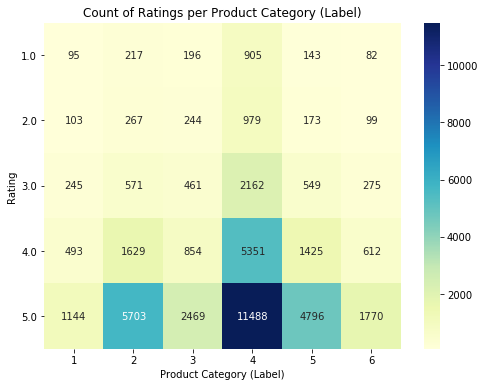

In [49]:
df = pd.DataFrame(data.groupby(['overall', 'Label']).size())
df.columns = ['Count']
df.reset_index(inplace=True)
df.rename(index=str, columns={'overall': 'Rating'}, inplace=True)
df = df.pivot('Rating', 'Label', 'Count').fillna(0)

plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of Ratings per Product Category (Label)')
plt.xlabel('Product Category (Label)')
plt.yticks(rotation=0)
plt.show()

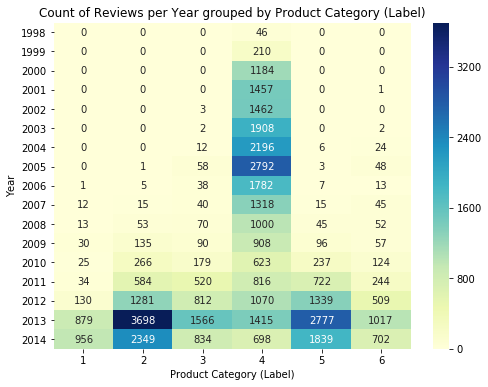

In [50]:
df = pd.DataFrame(data.groupby(['reviewYear', 'Label']).size())
df.columns = ['Count']
df.reset_index(inplace=True)
df.rename(index=str, columns={'reviewYear': 'Year'}, inplace=True)
df = df.pivot('Year', 'Label', 'Count').fillna(0).astype(int)

plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of Reviews per Year grouped by Product Category (Label)')
plt.xlabel('Product Category (Label)')
plt.yticks(rotation=0)
plt.show()

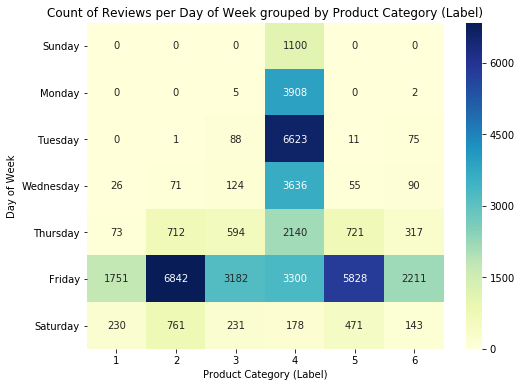

In [51]:
df = pd.DataFrame(data.groupby(['DayOfWeek', 'Label']).size())
df.columns = ['Count']
df.reset_index(inplace=True)
df = df.pivot('DayOfWeek', 'Label', 'Count').fillna(0).astype(int)
df = df.reindex(days)

plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of Reviews per Day of Week grouped by Product Category (Label)')
plt.xlabel('Product Category (Label)')
plt.ylabel('Day of Week')
plt.yticks(rotation=0)
plt.show()

In [52]:
data[['overall', 'reviewYear', 'reviewLength', 'sentimentSummary', 'Label']].corr()

,overall,reviewYear,reviewLength,sentimentSummary,Label
overall,1.000000,0.085502,-0.042731,0.291971,0.002132
reviewYear,0.085502,1.000000,-0.327348,0.129334,-0.202015
reviewLength,-0.042731,-0.327348,1.000000,-0.103182,0.087455
sentimentSummary,0.291971,0.129334,-0.103182,1.000000,-0.010209
Label,0.002132,-0.202015,0.087455,-0.010209,1.000000


## Model Selection

### Formatting

In [53]:
data['overall'] = data.overall.astype(str)
data['reviewYear'] = data.reviewYear.astype(str)

### Downsample for Balanced Classes

In [54]:
data1= data[data.Label == 1]
n = len(data1)
data2 = data[data.Label == 2].sample(n=n, replace=False, random_state=seed, axis=0)
data3 = data[data.Label == 3].sample(n=n, replace=False, random_state=seed, axis=0)
data4 = data[data.Label == 4].sample(n=n, replace=False, random_state=seed, axis=0)
data5 = data[data.Label == 5].sample(n=n, replace=False, random_state=seed, axis=0)
data6 = data[data.Label == 6].sample(n=n, replace=False, random_state=seed, axis=0)

data_resamp = pd.concat([data1,data2,data3,data4,data5,data6])
data_resamp.shape

(12480, 17)

### Train/Dev/Test Split (60/20/20)

In [55]:
X = data_resamp.loc[:, data_resamp.columns!='Label']
y = data_resamp.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.667, random_state=seed)

print('original data', data.shape)
print('resampled data', data_resamp.shape)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_dev', X_dev.shape)
print('y_dev', y_dev.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

original data (45500, 17)
resampled data (12480, 17)
X_train (8736, 16)
y_train (8736,)
X_dev (1246, 16)
y_dev (1246,)
X_test (2498, 16)
y_test (2498,)


### Standardize Numeric Features

0 mean, unit variance

In [56]:
scalerReviewLength = StandardScaler()
reviewLengthScaledTrain = scalerReviewLength.fit_transform(X_train.reviewLength.values.reshape(-1,1))
reviewLengthScaledTrain = [x for sublist in reviewLengthScaledTrain for x in sublist]

reviewLengthScaledDev = scalerReviewLength.transform(X_dev.reviewLength.values.reshape(-1,1))
reviewLengthScaledDev = [x for sublist in reviewLengthScaledDev for x in sublist]

reviewLengthScaledTest = scalerReviewLength.transform(X_test.reviewLength.values.reshape(-1,1))
reviewLengthScaledTest = [x for sublist in reviewLengthScaledTest for x in sublist]

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [57]:
scalerSentiment = StandardScaler()
sentimentScaledTrain = scalerSentiment.fit_transform(X_train.sentimentSummary.values.reshape(-1,1))
sentimentScaledTrain = [x for sublist in sentimentScaledTrain for x in sublist]

sentimentScaledDev = scalerSentiment.transform(X_dev.sentimentSummary.values.reshape(-1,1))
sentimentScaledDev = [x for sublist in sentimentScaledDev for x in sublist]

sentimentScaledTest = scalerSentiment.transform(X_test.sentimentSummary.values.reshape(-1,1))
sentimentScaledTest = [x for sublist in sentimentScaledTest for x in sublist]

In [58]:
X_train_numeric = pd.DataFrame({'reviewLength': reviewLengthScaledTrain, 'sentimentSummary': sentimentScaledTrain})
X_dev_numeric = pd.DataFrame({'reviewLength': reviewLengthScaledDev, 'sentimentSummary': sentimentScaledDev})
X_test_numeric = pd.DataFrame({'reviewLength': reviewLengthScaledTest, 'sentimentSummary': sentimentScaledTest})

### Convert Categorical Features to Dummy Variables

In [59]:
dummy_cols = ['asin', 'reviewerName', 'overall', 'reviewYear', 'reviewMonth', 'DayOfWeek', 'helpfulRank']

X_train_dummies = pd.get_dummies(X_train[dummy_cols])

print('X_train_dummies', X_train_dummies.shape)

X_train_dummies (8736, 9781)


In [60]:
X_dev_dummies = pd.get_dummies(X_dev[dummy_cols])
print('X_dev_dummies', X_dev_dummies.shape)

X_dev_dummies (1246, 2166)


In [61]:
X_test_dummies = pd.get_dummies(X_test[dummy_cols])
print('X_test_dummies', X_test_dummies.shape)

X_test_dummies (2498, 4012)


In [62]:
zeros = np.setdiff1d(X_train_dummies.columns, X_dev_dummies.columns)
df_zeros = pd.DataFrame(columns=zeros)
df_merged = pd.concat([X_dev_dummies, df_zeros], axis=1).fillna(0)[X_train_dummies.columns]
df_merged.shape

(1246, 9781)

In [63]:
zeros = np.setdiff1d(X_train_dummies.columns, X_test_dummies.columns)
df_zeros = pd.DataFrame(columns=zeros)
df_merged1 = pd.concat([X_test_dummies, df_zeros], axis=1).fillna(0)[X_train_dummies.columns]
df_merged1.shape

(2498, 9781)

### TF-IDF

In [64]:
vectorizer = TfidfVectorizer()
corpus = X_train.reviewText.apply(lambda x: ' '.join(x))
tfidf_matrix = vectorizer.fit_transform(corpus)
df_tfidf_train = pd.DataFrame(tfidf_matrix.todense())
df_tfidf_train.columns = vectorizer.get_feature_names()

corpus = X_dev.reviewText.apply(lambda x: ' '.join(x))
tfidf_matrix = vectorizer.transform(corpus)
df_tfidf_dev = pd.DataFrame(tfidf_matrix.todense())
df_tfidf_train.columns = vectorizer.get_feature_names()

corpus = X_test.reviewText.apply(lambda x: ' '.join(x))
tfidf_matrix = vectorizer.transform(corpus)
df_tfidf_test = pd.DataFrame(tfidf_matrix.todense())
df_tfidf_train.columns = vectorizer.get_feature_names()

### Merge Back Together

In [65]:
X_train_numeric.set_index(X_train_dummies.index, inplace=True)
df_tfidf_train.set_index(X_train_dummies.index, inplace=True)
X_train = pd.concat([X_train_numeric, X_train_dummies], axis=1)
X_train = pd.concat([X_train, df_tfidf_train], axis=1)
print('X_train', X_train.shape)

X_dev_numeric.set_index(df_merged.index, inplace=True)
df_tfidf_dev.set_index(df_merged.index, inplace=True)
X_dev = pd.concat([X_dev_numeric, df_merged], axis=1)
X_dev = pd.concat([X_dev, df_tfidf_dev], axis=1)
print('X_dev', X_dev.shape)

X_test_numeric.set_index(df_merged1.index, inplace=True)
df_tfidf_test.set_index(df_merged1.index, inplace=True)
X_test = pd.concat([X_test_numeric, df_merged1], axis=1)
X_test = pd.concat([X_test, df_tfidf_test], axis=1)
print('X_test', X_test.shape)

X_train (8736, 49622)
X_dev (1246, 49622)
X_test (2498, 49622)


In [66]:
X_train.head()

,reviewLength,sentimentSummary,asin_073533417X,asin_096625757X,asin_0975277324,asin_1223062341,asin_1223069192,asin_1564518531,asin_157982269X,asin_1581174837,...,zurg,zutons,zuwith,zwap,zwipes,zx3,zymol,zymolthere,zz,zzzzzzzzzzzzzz
61329,-0.462957,-0.296393,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18071,-0.406844,0.454541,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62069,0.084144,1.723726,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13795,-0.476985,1.469889,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60044,-0.154336,-0.306969,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

In [67]:
selector = VarianceThreshold(threshold=0.001)
selector.fit(X_train)

features = X_train[X_train.columns[selector.get_support(indices=True)]].columns

X_train = pd.DataFrame(selector.transform(X_train), index=X_train.index)
X_train.columns = features
X_dev = pd.DataFrame(selector.transform(X_dev), index=X_dev.index)
X_dev.columns = features
X_test = pd.DataFrame(selector.transform(X_test), index=X_test.index)
X_test.columns = features

print('X_train', X_train.shape)
print('X_dev', X_dev.shape)
print('X_test', X_test.shape)

X_train (8736, 201)
X_dev (1246, 201)
X_test (2498, 201)


### Tune Models

In [68]:
def best_parameters(array):
    max_acc = max([x['acc'] for x in array])
    for d in array:
        if d['acc'] == max_acc:
            print(d)

##### SVM

In [69]:
# svc_list = []
# for k in ['rbf', 'poly', 'sigmoid']:
#     for c in [4, 3, 2, 1]:
#         for g in ['auto', 0.5]:
#             clf = OneVsOneClassifier(SVC(kernel=k, C=c, gamma=g, random_state=seed))
#             clf.fit(X_train, y_train)
#             y_pred = clf.predict(X_dev)
#             acc = accuracy_score(y_dev, y_pred)

#             svc_dict = {'kernel': k, 'c': c, 'gamma': g, 'acc': acc}
#             svc_list.append(svc_dict)
            
# best_parameters(svc_list)

In [71]:
linear_svc_list = []
for p in ['l2']:
    for c in [4, 3.5, 3, 2.5, 2]:
        for l in ['hinge', 'squared_hinge']:
            clf = OneVsOneClassifier(LinearSVC(penalty=p, C=c, loss=l, random_state=seed))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_dev)
            acc = accuracy_score(y_dev, y_pred)

            linear_svc_dict = {'penalty': p, 'c': c, 'loss': l, 'acc': acc}
            linear_svc_list.append(linear_svc_dict)
            
best_parameters(linear_svc_list)

{'penalty': 'l2', 'c': 4, 'loss': 'squared_hinge', 'acc': 0.7849117174959872}
{'penalty': 'l2', 'c': 3, 'loss': 'squared_hinge', 'acc': 0.7849117174959872}
{'penalty': 'l2', 'c': 2.5, 'loss': 'squared_hinge', 'acc': 0.7849117174959872}


In [72]:
clf = OneVsOneClassifier(LinearSVC(penalty='l2', C=2.5, loss='squared_hinge', random_state=seed))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_dev)
acc = accuracy_score(y_dev, y_pred)
print(acc)

0.7849117174959872


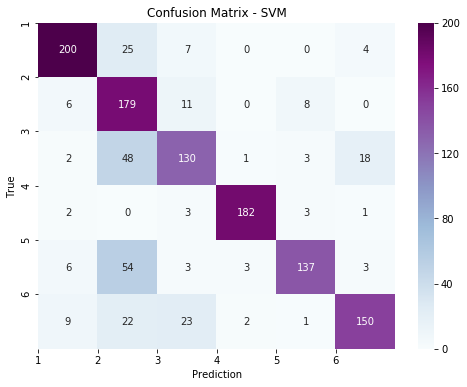

In [73]:
labels = range(1,7)

cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Prediction')
plt.xticks(range(0,6),labels)
plt.yticks(range(0,6),labels)
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()

##### k-NN

In [74]:
# knn_list = []
# for n in range(1,51):
#     for w in ['uniform', 'distance']:
#         for a in ['auto', 'ball_tree', 'kd_tree', 'brute']:
#             clf = KNeighborsClassifier(n_neighbors=n, weights=w, algorithm=a)
#             clf.fit(X_train, y_train)
#             y_pred = clf.predict(X_dev)
#             acc = accuracy_score(y_dev, y_pred)

#             knn_dict = {'n_neighbors': n, 'weights': w, 'algorithm': a, 'acc': acc}
#             knn_list.append(knn_dict)
            
# best_parameters(knn_list)

{'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'auto', 'acc': 0.406099518459069}
{'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'ball_tree', 'acc': 0.406099518459069}
{'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'kd_tree', 'acc': 0.406099518459069}
{'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'brute', 'acc': 0.406099518459069}
{'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'auto', 'acc': 0.406099518459069}
{'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'ball_tree', 'acc': 0.406099518459069}
{'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'kd_tree', 'acc': 0.406099518459069}
{'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'brute', 'acc': 0.406099518459069}


In [75]:
# clf = KNeighborsClassifier(n_neighbors=17, weights='distance', algorithm='auto')
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_dev)
# acc = accuracy_score(y_dev, y_pred)
# print(acc)

0.406099518459069


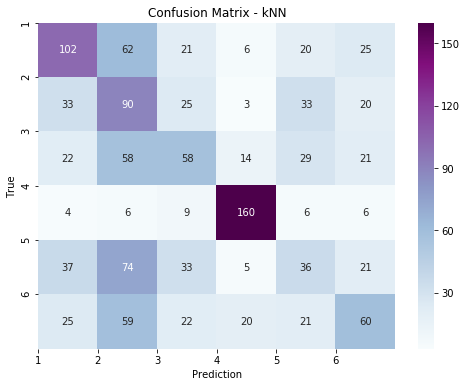

In [76]:
# cm = confusion_matrix(y_dev, y_pred)
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
# plt.xlabel('Prediction')
# plt.xticks(range(0,6),labels)
# plt.yticks(range(0,6),labels)
# plt.ylabel('True')
# plt.title('Confusion Matrix - kNN')
# plt.show()

##### Random Forest

In [78]:
rf_list = []
for d in [None,5,10]:
    for n in range(405,416):
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=seed)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)

        rf_dict = {'n_estimators': n, 'max_depth': d, 'acc': acc}
        rf_list.append(rf_dict)

best_parameters(rf_list)

{'n_estimators': 410, 'max_depth': None, 'acc': 0.7576243980738363}
{'n_estimators': 411, 'max_depth': None, 'acc': 0.7576243980738363}


In [79]:
clf = RandomForestClassifier(n_estimators=410, max_depth=None, random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_dev)
acc = accuracy_score(y_dev, y_pred)
print(acc)

0.7576243980738363


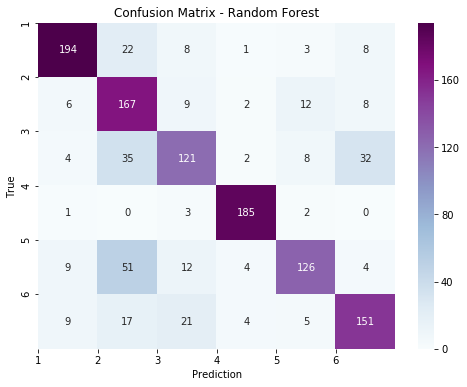

In [80]:
cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Prediction')
plt.xticks(range(0,6),labels)
plt.yticks(range(0,6),labels)
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [81]:
# Feature Importance
d = {'Feature': X_train.columns, 'Importance': clf.feature_importances_}
df_imp = pd.DataFrame(d).sort_values(ascending=False, by='Importance')
df_imp.head(20)

,Feature,Importance
143,album,0.052147
187,show,0.044056
0,reviewLength,0.038435
144,baby,0.037336
160,guitar,0.031413
1,sentimentSummary,0.028483
189,song,0.025131
183,season,0.022363
185,series,0.018878
170,nt,0.017071


##### Naive Bayes

In [82]:
clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_dev)
accuracy_score(y_dev, y_pred)

0.630016051364366

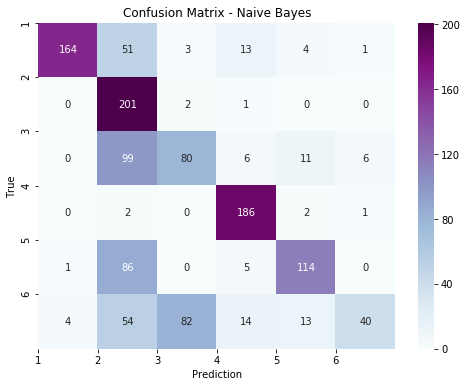

In [83]:
cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Prediction')
plt.xticks(range(0,6),labels)
plt.yticks(range(0,6),labels)
plt.ylabel('True')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

##### AdaBoost 

In [84]:
ada_list = []
for d in [None,1,2,3,4,5]:
    for n in range(40,51,1):
        clf = OneVsOneClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), 
                                                    n_estimators=n, random_state=seed))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)

        ada_dict = {'n_estimators': n, 'max_depth': d, 'acc': acc}
        ada_list.append(ada_dict)

best_parameters(ada_list)

{'n_estimators': 49, 'max_depth': 2, 'acc': 0.7704654895666132}


In [85]:
clf = OneVsOneClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), 
                                                    n_estimators=49, random_state=seed))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_dev)
acc = accuracy_score(y_dev, y_pred)
print(acc)

0.7704654895666132


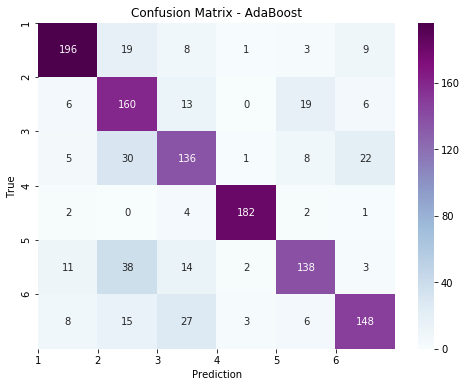

In [86]:
cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Prediction')
plt.xticks(range(0,6),labels)
plt.yticks(range(0,6),labels)
plt.ylabel('True')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

##### Quadratic Dicsriminant Analysis

In [87]:
# clf = QuadraticDiscriminantAnalysis()
# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_dev)
# accuracy_score(y_dev, y_pred)

In [88]:
# cm = confusion_matrix(y_dev, y_pred)
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
# plt.xlabel('Prediction')
# plt.xticks(range(0,6),labels)
# plt.yticks(range(0,6),labels)
# plt.ylabel('True')
# plt.title('Confusion Matrix - QDA')
# plt.show()

##### Linear Dicsriminant Analysis

In [89]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_dev)
accuracy_score(y_dev, y_pred)

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.7463884430176565

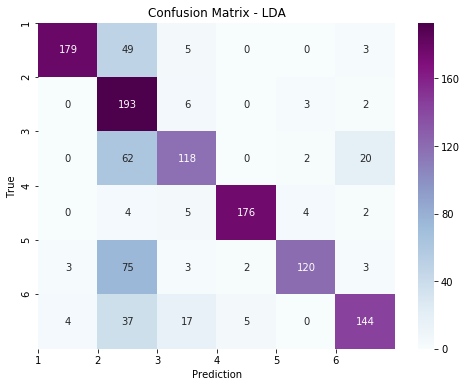

In [90]:
cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Prediction')
plt.xticks(range(0,6),labels)
plt.yticks(range(0,6),labels)
plt.ylabel('True')
plt.title('Confusion Matrix - LDA')
plt.show()

##### Perceptron

In [91]:
perceptron_list = []
for p in ['l1', 'l2', 'elasticnet']:
    for a in [0.0001, 0.001]:
        clf = OneVsOneClassifier(Perceptron(penalty=p, alpha=a, max_iter=1000))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)

        perceptron_dict = {'penalty':p, 'alpha': a, 'acc': acc}
        perceptron_list.append(perceptron_dict)

best_parameters(perceptron_list)

{'penalty': 'l1', 'alpha': 0.0001, 'acc': 0.723916532905297}


In [92]:
clf = OneVsOneClassifier(Perceptron(penalty='l1', alpha=0.0001, max_iter=1000))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_dev)
acc = accuracy_score(y_dev, y_pred)
print(acc)

0.723916532905297


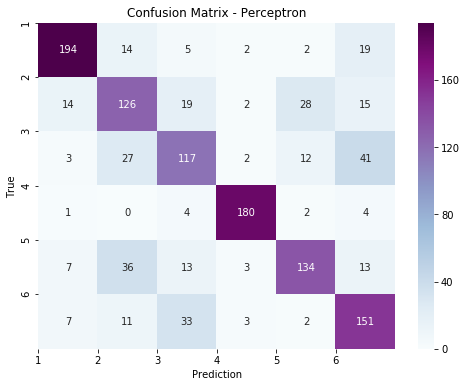

In [93]:
cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Prediction')
plt.xticks(range(0,6),labels)
plt.yticks(range(0,6),labels)
plt.ylabel('True')
plt.title('Confusion Matrix - Perceptron')
plt.show()

##### Voting Classifier

In [94]:
clf1 = OneVsOneClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), 
                                                    n_estimators=49, random_state=seed))
clf2 = RandomForestClassifier(n_estimators=410, max_depth=None, random_state=seed)
clf3 = OneVsOneClassifier(LinearSVC(penalty='l2', C=2.5, loss='squared_hinge', random_state=seed))

eclf1 = VotingClassifier(estimators=[('ada', clf1), ('rf', clf2), ('svm', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_dev)
acc = accuracy_score(y_dev, y_pred)

print(acc)

0.7857142857142857


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


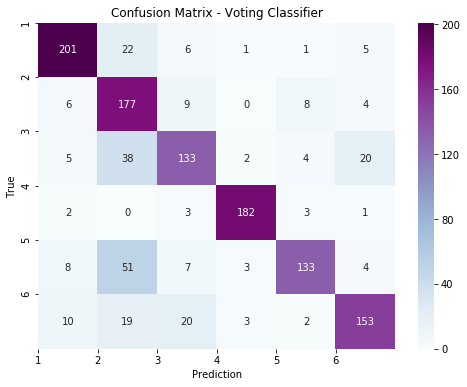

In [95]:
cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Prediction')
plt.xticks(range(0,6),labels)
plt.yticks(range(0,6),labels)
plt.ylabel('True')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()

## Model Assessment

In [96]:
# Combine train & dev sets
X_train = pd.concat([X_train, X_dev], axis=0)
y_train = pd.concat([y_train, y_dev], axis=0)

In [97]:
# SVM
clf = OneVsOneClassifier(LinearSVC(penalty='l2', C=2.5, loss='squared_hinge', random_state=seed))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('SVM', acc)

# # kNN
# clf = KNeighborsClassifier(n_neighbors=44, weights='distance', algorithm='brute')
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print('kNN', acc)

# Random Forest
clf = RandomForestClassifier(n_estimators=410, max_depth=None, random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Random Forest', acc)

# Naive Bayes
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Naive Bayes', acc)

# AdaBoost
clf = OneVsOneClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), 
                                                    n_estimators=49, random_state=seed))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('AdaBoost', acc)

# LDA
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('LDA', acc)

# Perceptron
clf = OneVsOneClassifier(Perceptron(penalty='l1', alpha=0.0001, max_iter=1000))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Perceptron', acc)

# Voting Classifier
clf1 = OneVsOneClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), 
                                                    n_estimators=49, random_state=seed))
clf2 = RandomForestClassifier(n_estimators=410, max_depth=None, random_state=seed)
clf3 = OneVsOneClassifier(LinearSVC(penalty='l2', C=2.5, loss='squared_hinge', random_state=seed))

eclf1 = VotingClassifier(estimators=[('ada', clf1), ('rf', clf2), ('svm', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Voting Classifier', acc)

SVM 0.765812650120096
Random Forest 0.7429943955164131
Naive Bayes 0.6080864691753403
AdaBoost 0.7373899119295436


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA 0.7261809447558046
Perceptron 0.732986389111289
Voting Classifier 0.732986389111289
